In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import yfinance as yf

data = yf.download(tickers = "6E=F", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1.19005,1.19500,1.18600,1.19030,1.19030,289430
2017-12-04,1.18785,1.18875,1.18380,1.18660,1.18660,170174
2017-12-05,1.18755,1.18855,1.18080,1.18230,1.18230,185404
2017-12-06,1.18370,1.18560,1.17880,1.17985,1.17985,197952
2017-12-07,1.18085,1.18210,1.17770,1.17790,1.17790,197235
...,...,...,...,...,...,...
2023-06-09,1.07880,1.07905,1.07475,1.07545,1.07545,230751
2023-06-12,1.07525,1.07945,1.07375,1.07600,1.07600,349852
2023-06-13,1.07600,1.08280,1.07600,1.07935,1.07935,535272


In [3]:
data = data.reset_index('Date', inplace=False)

In [4]:
# Chuyển cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thứ tự tăng dần của cột 'Date'
data.sort_values(by='Date', inplace=True)

# Chuyển cột 'Date' thành mảng numpy
dates = data['Date'].values

# Chuyển cột 'Close' thành mảng numpy
close_prices = data['Close'].values

In [5]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [6]:
train_dates = train_data['Date'].values
train_close_prices = train_data['Close'].values
val_dates = val_data['Date'].values
val_close_prices = val_data['Close'].values
test_dates = test_data['Date'].values
test_close_prices = test_data['Close'].values

In [7]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values

In [8]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [9]:
# Xác định kiến trúc của mạng Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Xác định hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [11]:
# Khởi tạo mô hình BNN
model = BNN(input_size=1, output_size=1)

In [12]:
# Huấn luyện mô hình BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 331.29901123046875
Epoch [200/1000], Loss: 196.5079345703125
Epoch [300/1000], Loss: 18.348848342895508
Epoch [400/1000], Loss: 20.29149055480957
Epoch [500/1000], Loss: 2.8599469661712646
Epoch [600/1000], Loss: 350.8708801269531
Epoch [700/1000], Loss: 1.5598400831222534
Epoch [800/1000], Loss: 311.9237365722656
Epoch [900/1000], Loss: 96.17478942871094
Epoch [1000/1000], Loss: 11.500659942626953


In [13]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [14]:
# Dự đoán trên tập validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [15]:
# In kết quả dự đoán trên tập test
print('Kết quả dự đoán trên tập test:')
for i in range(len(test_dates)):
    print(f'Date: {test_dates[i]}, Predicted Close: {y_pred_test[i].item()}')

Kết quả dự đoán trên tập test:
Date: 976, Predicted Close: -3.523548126220703
Date: 977, Predicted Close: -3.526698589324951
Date: 978, Predicted Close: -3.5298495292663574
Date: 979, Predicted Close: -3.5329995155334473
Date: 980, Predicted Close: -3.5361504554748535
Date: 981, Predicted Close: -3.5393009185791016
Date: 982, Predicted Close: -3.5424513816833496
Date: 983, Predicted Close: -3.545602321624756
Date: 984, Predicted Close: -3.548752784729004
Date: 985, Predicted Close: -3.551903247833252
Date: 986, Predicted Close: -3.5550537109375
Date: 987, Predicted Close: -3.5582046508789062
Date: 988, Predicted Close: -3.5613551139831543
Date: 989, Predicted Close: -3.5645060539245605
Date: 990, Predicted Close: -3.5676565170288086
Date: 991, Predicted Close: -3.5708069801330566
Date: 992, Predicted Close: -3.5739574432373047
Date: 993, Predicted Close: -3.577108383178711
Date: 994, Predicted Close: -3.580258846282959
Date: 995, Predicted Close: -3.583409309387207
Date: 996, Predicted

In [16]:
# In kết quả dự đoán trên tập validation
print('Kết quả dự đoán trên tập validation:')
for i in range(len(val_dates)):
    print(f'Date: {val_dates[i]}, Predicted Close: {y_pred_val[i].item()}')


Kết quả dự đoán trên tập validation:
Date: 1255, Predicted Close: -4.402562618255615
Date: 1256, Predicted Close: -4.4057135581970215
Date: 1257, Predicted Close: -4.4088640213012695
Date: 1258, Predicted Close: -4.412014484405518
Date: 1259, Predicted Close: -4.415164947509766
Date: 1260, Predicted Close: -4.418315410614014
Date: 1261, Predicted Close: -4.42146635055542
Date: 1262, Predicted Close: -4.424616813659668
Date: 1263, Predicted Close: -4.427767276763916
Date: 1264, Predicted Close: -4.430918216705322
Date: 1265, Predicted Close: -4.43406867980957
Date: 1266, Predicted Close: -4.437219142913818
Date: 1267, Predicted Close: -4.440369606018066
Date: 1268, Predicted Close: -4.443520545959473
Date: 1269, Predicted Close: -4.4466705322265625
Date: 1270, Predicted Close: -4.449821472167969
Date: 1271, Predicted Close: -4.452971935272217
Date: 1272, Predicted Close: -4.456122875213623
Date: 1273, Predicted Close: -4.459273338317871
Date: 1274, Predicted Close: -4.462423801422119
Da

In [17]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
#x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()
# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'Date: {x_next_30_days[i]}, Predicted Close: {y_pred_next[i]}')

Date: tensor([1395.]), Predicted Close: -4.843645095825195
Date: tensor([1396.]), Predicted Close: -4.846796035766602
Date: tensor([1397.]), Predicted Close: -4.849946022033691
Date: tensor([1398.]), Predicted Close: -4.8530964851379395
Date: tensor([1399.]), Predicted Close: -4.856247425079346
Date: tensor([1400.]), Predicted Close: -4.859398365020752
Date: tensor([1401.]), Predicted Close: -4.862548828125
Date: tensor([1402.]), Predicted Close: -4.865699291229248
Date: tensor([1403.]), Predicted Close: -4.868850231170654
Date: tensor([1404.]), Predicted Close: -4.872000217437744
Date: tensor([1405.]), Predicted Close: -4.87515115737915
Date: tensor([1406.]), Predicted Close: -4.878301620483398
Date: tensor([1407.]), Predicted Close: -4.8814520835876465
Date: tensor([1408.]), Predicted Close: -4.884603023529053
Date: tensor([1409.]), Predicted Close: -4.887753009796143
Date: tensor([1410.]), Predicted Close: -4.890903949737549
Date: tensor([1411.]), Predicted Close: -4.894054412841797

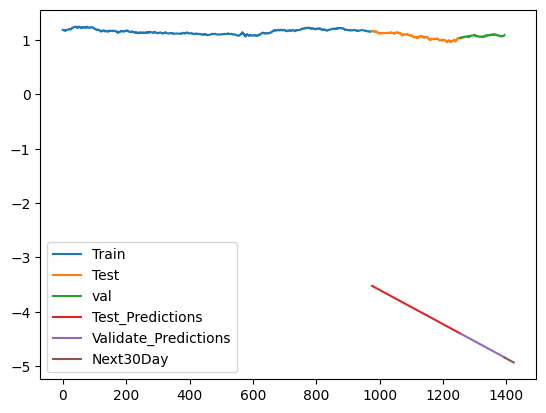

In [18]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()